#1. Problem Definition

The goal is to predict the **probability that a borrower will repay their loan** based on their financial and personal attributes.

This can help to **assess credit risk**, **reduce loan defaults**, and **improve decision-making** when approving loans.

**Evaluation Metric:**  
Area Under the ROC Curve (AUC-ROC)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

#  2. Load and Preview the Data

In [5]:
train = pd.read_csv('/workspaces/Loan-Payback-Prediction-Model/Datasets/train.csv')
test = pd.read_csv('/workspaces/Loan-Payback-Prediction-Model/Datasets/test.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()

Train shape: (593994, 13)
Test shape: (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


#  3. Exploratory Data Analysis (EDA)
Understand structure, check missing values, and look for patterns that may influence loan repayment.

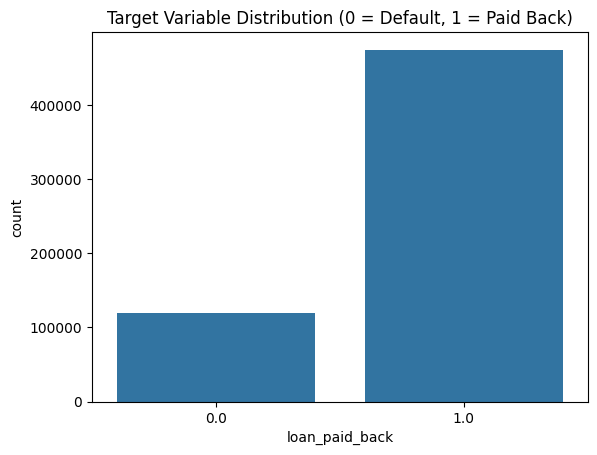

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

In [6]:
sns.countplot(x='loan_paid_back', data=train)
plt.title('Target Variable Distribution (0 = Default, 1 = Paid Back)')
plt.show()
train['loan_paid_back'].value_counts(normalize=True)

In [7]:
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)

Series([], dtype: int64)


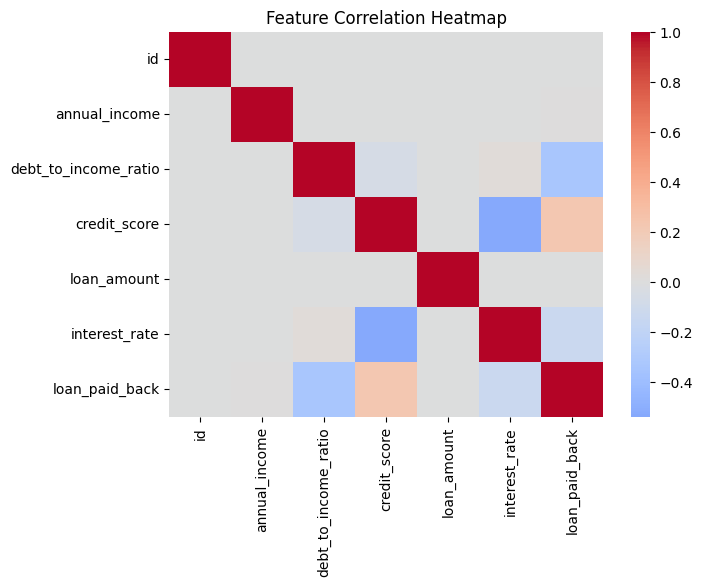

In [8]:
plt.figure(figsize=(7,5))
sns.heatmap(train.corr(numeric_only=True), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

#  4. Data Preparation
We'll:
1. Separate features and target  
2. Handle missing values  
3. Encode categorical variables  
4. Scale numerical features  
5. Split the data into training and validation sets

In [9]:
X = train.drop(['loan_paid_back', 'id'], axis=1, errors='ignore')
y = train['loan_paid_back']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

Categorical: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Numeric: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']


**Preprocessing Step**

The `preprocessor` object automatically handles all feature transformations before data reaches the model.  
By placing it inside a scikit-learn `Pipeline`, we ensure:
- The same preprocessing is applied during both training and prediction.
- No data leakage (transformers fit only on the training data).
- A clean, deployable workflow.
Next, we’ll integrate this `preprocessor` into several model pipelines and evaluate their performance using ROC-AUC.


[Scikit-learn preprocessor](https://scikit-learn.org/stable/modules/preprocessing.html)



In [10]:
# Drop rows with missing values in key predictor and target columns
X = X.dropna(subset=[
    'annual_income', 'debt_to_income_ratio', 'credit_score',
    'loan_amount', 'interest_rate', 'gender', 'marital_status',
    'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade'
])
y = y.dropna()

# Split data into training and validation sets (80/20) with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=19
)

# Define preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine both pipelines into a single preprocessor using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


#  5. Model Training and Comparison

**Logistic Regression Pipeline**

In [11]:
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=500))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict_proba(X_val)[:, 1]
auc_lr = roc_auc_score(y_val, y_pred_lr)
print('Logistic Regression AUC:', auc_lr)

Logistic Regression AUC: 0.9113729346518193


**Random Forest Pipeline**

In [12]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=10, random_state=19, n_jobs=-1,))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_rf)
print('Random Forest AUC:', auc_rf)

Random Forest AUC: 0.8798204785964696


**Parameter tuning for Random Forests.**

In [13]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
    n_estimators=75,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=5,
    n_jobs=-1,
    criterion='gini',
    random_state=19
))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict_proba(X_val)[:, 1]
auc_rf = roc_auc_score(y_val, y_pred_rf)
print('Random Forest AUC:', auc_rf)

Random Forest AUC: 0.907469481647985


In [14]:
# Range of n_estimators to test
n_estimators_range = range(10, 201, 10)  # 10 \u2192 200 in steps of 10
auc_scores = []
best_auc = 0
stop_improving_at = None
improvement_threshold = 0.0005  # Minimum AUC improvement to continue

for n_est in n_estimators_range:
    rf_pipeline_loop = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=n_est,
            random_state=19,
            n_jobs=-1,
            max_depth=10,           # keep trees shallow for speed
            max_features='sqrt',    # efficient feature sampling
            criterion='gini'        # faster split criterion
        ))
    ])

    rf_pipeline_loop.fit(X_train, y_train)
    y_pred = rf_pipeline_loop.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

    print(f"n_estimators={n_est:3d}: AUC = {auc:.6f}")

    # Check improvement
    if auc - best_auc < improvement_threshold:
        if stop_improving_at is None:
            stop_improving_at = n_est
        elif n_est - stop_improving_at >= 30:  # if no improvement for 3 steps
            print(f"\n\u23f9\ufe0f  Stopping early at n_estimators={n_est} (no significant improvement)")
            break
    else:
        stop_improving_at = None
        best_auc = auc

print("\n\u2705 Best AUC:", best_auc)

n_estimators= 10: AUC = 0.902857
n_estimators= 20: AUC = 0.905729
n_estimators= 30: AUC = 0.905883
n_estimators= 40: AUC = 0.905274
n_estimators= 50: AUC = 0.906088
n_estimators= 60: AUC = 0.906404
n_estimators= 70: AUC = 0.906560
n_estimators= 80: AUC = 0.906494
n_estimators= 90: AUC = 0.906849
n_estimators=100: AUC = 0.906898

⏹️  Stopping early at n_estimators=100 (no significant improvement)

✅ Best AUC: 0.9064044892299283


**XGBoost Pipeline**

In [18]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=19))
])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print('XGBoost AUC:', auc_xgb)

XGBoost AUC: 0.9218084974816432


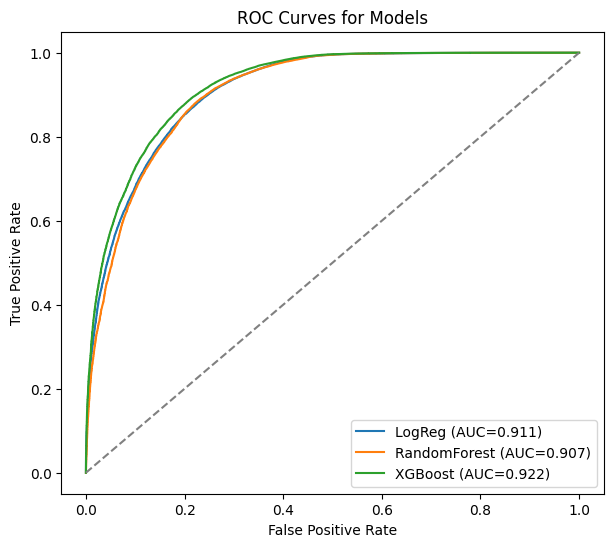

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_xgb)

plt.figure(figsize=(7,6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [23]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

#  Define the base model
xgb = XGBClassifier(
    eval_metric='auc',
    use_label_encoder=False,
    random_state=19,
    tree_method='hist',  # fast CPU-based algorithm
    n_jobs=-1
)

#  Create a pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb)
])

# Define parameter search space
param_distributions = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 8),
    'model__gamma': uniform(0, 0.5)
}

# Randomized Search Setup
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=30,                 # number of random combos to test
    scoring='roc_auc',
    n_jobs=-1,
    cv=3,                      # 3-fold CV
    verbose=2,
    random_state=19
)

# Run the search
random_search.fit(X_train, y_train)

# Evaluate on validation set
best_model = random_search.best_estimator_
y_pred_xgb = best_model.predict_proba(X_val)[:, 1]
auc_xgb = roc_auc_score(y_val, y_pred_xgb)

print("\n✅ Best parameters:")
print(random_search.best_params_)
print(f"Validation AUC: {auc_xgb:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/conda/envs/Portfolio/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/envs/Portfolio/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoos

[CV] END model__colsample_bytree=0.6390134406997806, model__gamma=0.38062485833742815, model__learning_rate=0.08408139194989811, model__max_depth=7, model__min_child_weight=3, model__n_estimators=259, model__subsample=0.8702530684560523; total time=  16.1s
[CV] END model__colsample_bytree=0.6390134406997806, model__gamma=0.38062485833742815, model__learning_rate=0.08408139194989811, model__max_depth=7, model__min_child_weight=3, model__n_estimators=259, model__subsample=0.8702530684560523; total time=  16.2s
[CV] END model__colsample_bytree=0.6160853882788928, model__gamma=0.05876778366637897, model__learning_rate=0.012444478085805268, model__max_depth=5, model__min_child_weight=5, model__n_estimators=267, model__subsample=0.6863693024188722; total time=  13.8s
[CV] END model__colsample_bytree=0.6390134406997806, model__gamma=0.38062485833742815, model__learning_rate=0.08408139194989811, model__max_depth=7, model__min_child_weight=3, model__n_estimators=259, model__subsample=0.87025306

In [24]:
xgb_pipeline.fit(X, y)
test_pred = xgb_pipeline.predict_proba(test.drop(['id'], axis=1, errors='ignore'))[:, 1]
submission = pd.DataFrame({'id': test['id'], 'loan_paid_back': test_pred})
submission.to_csv('submission.csv', index=False)
print('✅ Submission file created: submission.csv')

✅ Submission file created: submission.csv
